In [11]:
import pandas as pd
import numpy as np
import os
import sys
p = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))
sys.path.append(p)

from Game.ConnectFour import ConnectFour
from MCTS.node import Node
from MCTS.MCTS import MonteCarlo_Single
from MCTS.MCTS_optimized import MonteCarlo
import utils.config as config

import timeit

In [12]:
random_positions = pd.read_csv(os.path.join(p, 'datasets', 'positions.csv'), delimiter=';', header=None)
cel_columns = [f'cel{i}' for i in range(1, 43)]

random_positions.columns = cel_columns + ['pieces', 'turn']
def add_empty_board(data):
    # Create an empty board with the same structure as the existing DataFrame
    empty_board = {f'cel{i}': 0 for i in range(1, 43)} 
    empty_board['pieces'] = 0
    empty_board['turn'] = 1

    # Append the new row to the DataFrame
    data = pd.concat([data, pd.DataFrame([empty_board])], ignore_index=True)
    return data


# Append the new row to the DataFrame
random_positions = add_empty_board(random_positions)
random_positions.loc[random_positions['turn'] == -1, cel_columns] *= -1  # Flip -1 to 1 and 1 to -1
random_positions

,cel1,cel2,cel3,cel4,cel5,cel6,cel7,cel8,cel9,cel10,...,cel35,cel36,cel37,cel38,cel39,cel40,cel41,cel42,pieces,turn
0,0,-1,0,0,-1,0,1,-1,1,0,...,1,-1,1,1,1,-1,1,-1,33,-1
1,0,0,0,0,0,0,0,0,0,0,...,-1,0,-1,-1,1,1,-1,1,12,1
2,0,0,0,0,0,0,0,0,0,0,...,1,0,-1,1,1,-1,-1,-1,13,-1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,-1,-1,1,-1,1,1,7,-1
4,0,0,0,0,0,-1,0,0,0,0,...,-1,-1,1,0,1,-1,1,-1,17,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59996,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,-1,-1,-1,12,1
59997,0,0,0,0,0,0,0,0,0,0,...,0,-1,1,0,-1,0,-1,-1,13,-1
59998,0,0,0,0,0,0,0,0,0,0,...,1,-1,-1,-1,0,1,1,1,8,1
59999,0,-1,-1,1,0,0,0,0,-1,-1,...,1,1,-1,1,1,1,-1,-1,30,1


In [13]:
def MCTS_benchmark(row, threads, iterations):
    board = row[cel_columns].values.reshape(6, 7)

    game = ConnectFour()
    game.board = board
    game.turn = 1

    root = Node(game)
    
    if (threads == 'single'):
        monte_carlo = MonteCarlo_Single(iteration=iterations)

    elif (threads == 'multi'):
        monte_carlo = MonteCarlo(iteration=iterations)
    else:
        raise ValueError("threads must be 'single' or 'multi'")
    
    # Perform the search to determine the best move
    start_time = timeit.default_timer()
    played_column, _ = monte_carlo.search(root)
    end_time = timeit.default_timer()

    return played_column, end_time - start_time

def run_benchmark(benchmark_data, data_path):

    threads = ['single', 'multi']
    iterations = [config.EASYLEVEL, config.MEDIUMLEVEL, config.HARDLEVEL]
    for thread in threads:
        for iteration in iterations:
            print(f"Running benchmark with {thread} threads and {iteration} iterations")
            for _, row in benchmark_data.iterrows():
                pieces = row['pieces']
                played_column, elapsed_time = MCTS_benchmark(row, thread, iteration)
                with open(data_path, 'a') as f:
                    f.write(f"{thread};{iteration};{pieces};{played_column};{elapsed_time}\n")


In [14]:
benchmark_data = random_positions.groupby('pieces').apply(lambda x: x.sample(n=min(10, len(x)), random_state=42)).reset_index(drop=True)
benchmark_data


,cel1,cel2,cel3,cel4,cel5,cel6,cel7,cel8,cel9,cel10,...,cel35,cel36,cel37,cel38,cel39,cel40,cel41,cel42,pieces,turn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1,0,0,0,1,-1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-1,0,0,0,0,1,-1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-1,0,1,-1
4,0,0,0,0,0,0,0,0,0,0,...,0,-1,0,0,0,0,0,0,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,-1,1,0,-1,1,1,1,-1,1,-1,...,1,-1,1,-1,1,1,-1,-1,41,-1
403,-1,-1,0,1,1,1,-1,1,1,-1,...,1,-1,1,-1,-1,1,-1,-1,41,-1
404,1,-1,1,-1,-1,0,1,1,1,-1,...,1,-1,-1,-1,1,-1,1,1,41,-1
405,1,-1,1,1,0,-1,-1,-1,1,1,...,1,-1,-1,1,-1,-1,1,1,41,-1


In [15]:
benchmark_data['pieces'].value_counts().sort_values(ascending=True)

0      1
1      7
41     9
38    10
2     10
3     10
4     10
5     10
6     10
7     10
8     10
10    10
11    10
12    10
13    10
14    10
15    10
16    10
17    10
9     10
18    10
21    10
40    10
29    10
22    10
23    10
24    10
25    10
26    10
27    10
28    10
30    10
20    10
31    10
32    10
33    10
34    10
35    10
36    10
37    10
19    10
39    10
Name: pieces, dtype: int64

In [16]:
print ("DANGER: you are about to overwrite the file with new data")
print ("This process will take a long time to run and will overwrite the file, potentially losing the already generated data")
string = input("Are you sure you want to continue? (yes/no): ")
if (string == "yes"):
    data_path = os.path.join(p, 'datasets', 'MCTS_benchmark.csv')
    with open(data_path, 'w') as f:
        f.write("threads;iterations;pieces;played_column;time\n")
    run_benchmark(benchmark_data=benchmark_data, data_path=data_path)  
#                            # PLEASE BE CAREFUL WITH THIS FUNCTION, IT WILL TAKE A LONG TIME TO RUN AND WILL OVERWRITE THE FILE
#                            # POTENTIALLY LOSING THE ALREADY GENERATED DATA

DANGER: you are about to overwrite the file with new data
This process will take a long time to run and will overwrite the file, potentially losing the already generated data
Running benchmark with single threads and 500 iterations
Running benchmark with single threads and 5000 iterations
Running benchmark with single threads and 10000 iterations
Running benchmark with multi threads and 500 iterations
Running benchmark with multi threads and 5000 iterations
Running benchmark with multi threads and 10000 iterations


In [17]:
benchmark_data = pd.read_csv(data_path, delimiter=';')
benchmark_data

,threads,iterations,pieces,played_column,time
0,single,500,0,2,0.673871
1,single,500,1,3,0.595069
2,single,500,1,2,0.558288
3,single,500,1,0,0.514171
4,single,500,1,3,0.490126
...,...,...,...,...,...
2434,multi,10000,41,2,0.732294
2435,multi,10000,41,2,0.745777
2436,multi,10000,41,5,0.767746
2437,multi,10000,41,4,0.719487


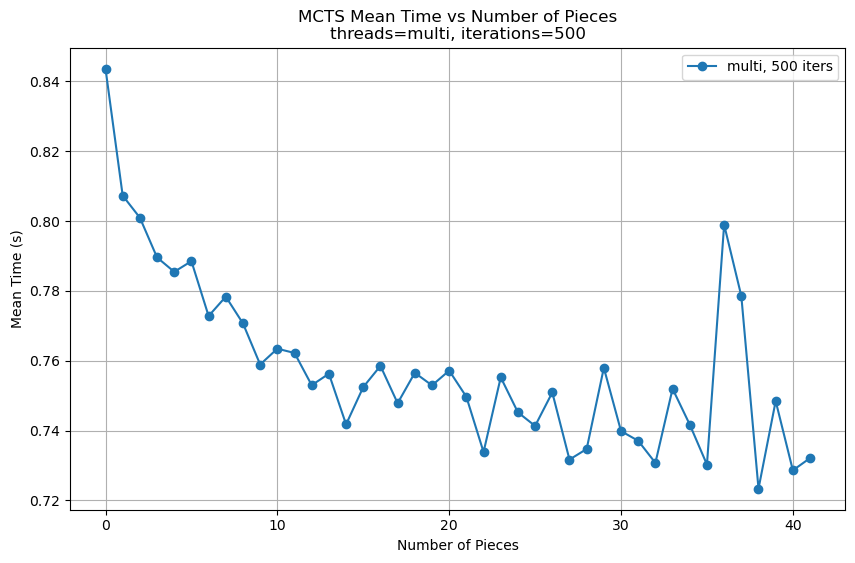

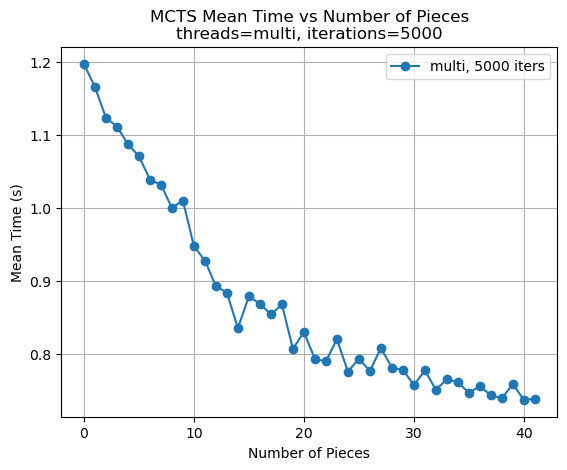

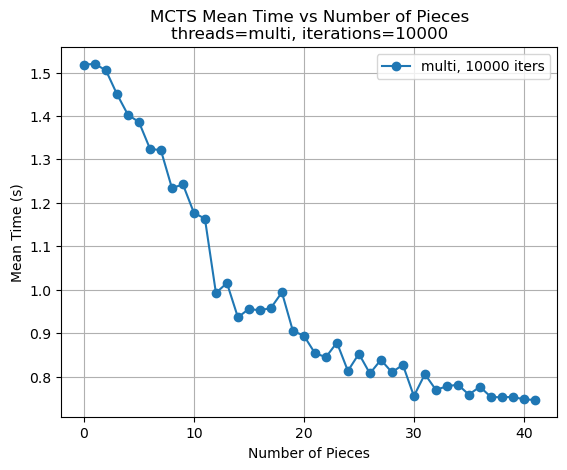

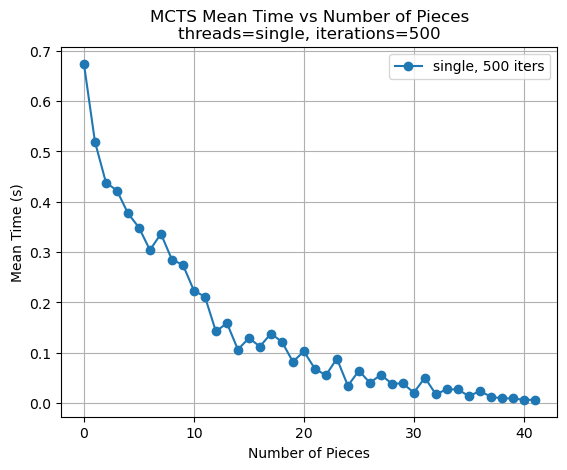

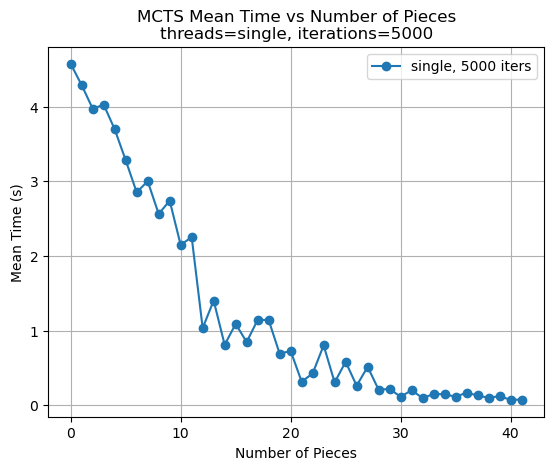

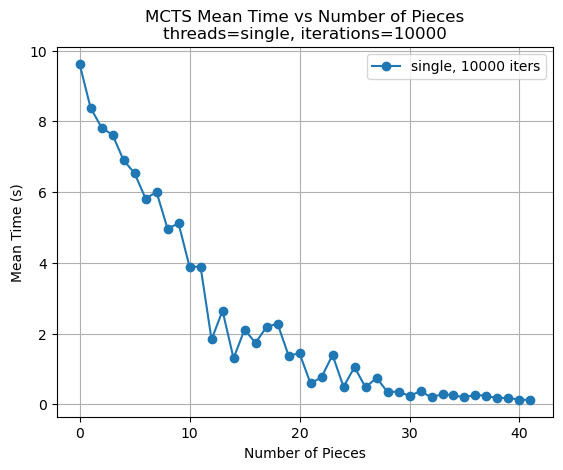

In [18]:
mean_times = benchmark_data.groupby(['threads', 'iterations', 'pieces'])['time'].mean().reset_index()
mean_times

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for (thread, iteration), subset in mean_times.groupby(['threads', 'iterations']):
    plt.plot(subset['pieces'], subset['time'], marker='o', label=f"{thread}, {iteration} iters")
    plt.xlabel('Number of Pieces')
    plt.ylabel('Mean Time (s)')
    plt.title(f'MCTS Mean Time vs Number of Pieces\nthreads={thread}, iterations={iteration}')
    plt.legend()
    plt.grid(True)
    plt.show()

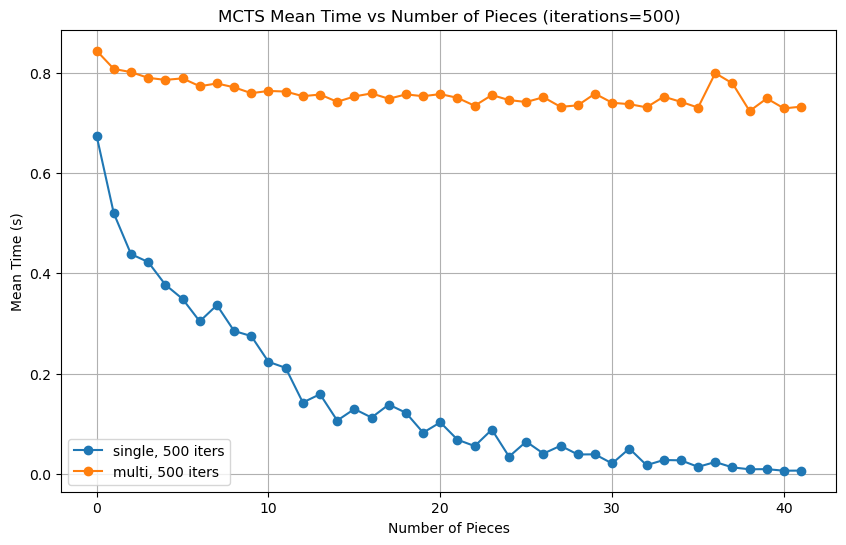

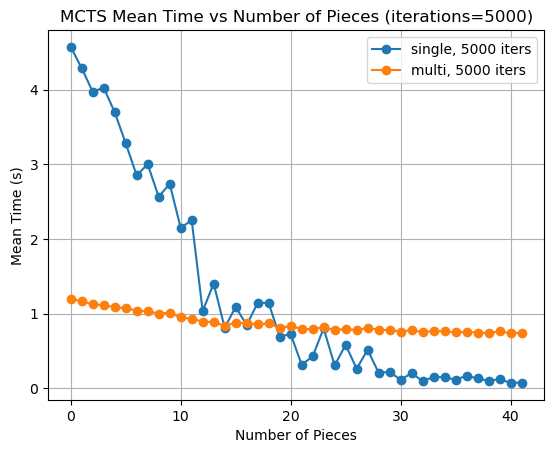

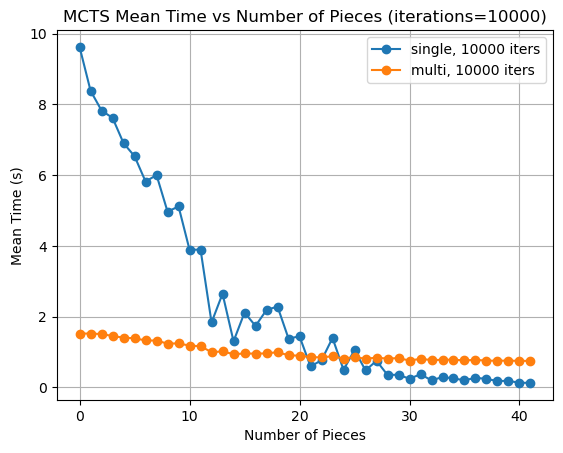

In [19]:
plt.figure(figsize=(10, 6))
for iteration in mean_times['iterations'].unique():
    subset = mean_times[mean_times['iterations'] == iteration]
    for thread in ['single', 'multi']:
        thread_subset = subset[subset['threads'] == thread]
        plt.plot(thread_subset['pieces'], thread_subset['time'], marker='o', label=f"{thread}, {iteration} iters")
    plt.xlabel('Number of Pieces')
    plt.ylabel('Mean Time (s)')
    plt.title(f'MCTS Mean Time vs Number of Pieces (iterations={iteration})')
    plt.legend()
    plt.grid(True)
    plt.show()

In [30]:
# Resetar índices
single_df = benchmark_data[benchmark_data['threads'] == 'single'].copy().reset_index(drop=True)
multi_df = benchmark_data[benchmark_data['threads'] == 'multi'].copy().reset_index(drop=True)
single_df
single_df['pieces'].value_counts().sort_values(ascending=True)


0      3
1     21
41    27
38    30
2     30
3     30
4     30
5     30
6     30
7     30
8     30
10    30
11    30
12    30
13    30
14    30
15    30
16    30
17    30
9     30
18    30
21    30
40    30
29    30
22    30
23    30
24    30
25    30
26    30
27    30
28    30
30    30
20    30
31    30
32    30
33    30
34    30
35    30
36    30
37    30
19    30
39    30
Name: pieces, dtype: int64

In [31]:
multi_df
multi_df['pieces'].value_counts().sort_values(ascending=True)

0      3
1     21
41    27
7     29
31    29
8     29
2     30
3     30
4     30
5     30
6     30
17    30
11    30
10    30
13    30
14    30
15    30
16    30
38    30
9     30
12    30
21    30
20    30
28    30
40    30
22    30
23    30
24    30
25    30
26    30
27    30
29    30
39    30
30    30
32    30
33    30
34    30
35    30
36    30
37    30
19    30
18    30
Name: pieces, dtype: int64

In [32]:
# Remove as linhas onde 'pieces' é 7, 8 ou 31 dos dataframes single_df e multi_df
single_df = single_df[~single_df['pieces'].isin([7, 8, 31])].reset_index(drop=True)
multi_df = multi_df[~multi_df['pieces'].isin([7, 8, 31])].reset_index(drop=True)

In [ ]:
diff_mask = single_df['played_column'] != multi_df['played_column']

single_df['is_different'] = diff_mask

# Filtrar por dificuldade
levels = {
    'easy': config.EASYLEVEL,
    'medium': config.MEDIUMLEVEL,
    'hard': config.HARDLEVEL
}

# Calcular e exibir o percentual de diferença por nível
for level_name, level_value in levels.items():
    subset = single_df[single_df['iterations'] == level_value]
    total = len(subset)
    different = subset['is_different'].sum()
    percentage = (different / total * 100) if total > 0 else 0
    print(f"Percentage of different moves for {level_name} level: {percentage:.2f}%")


Percentage of different moves for easy level: 34.75%
Percentage of different moves for medium level: 25.20%
Percentage of different moves for hard level: 25.73%
